In [11]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# pd.set_option("display.max_columns", 100)
# pd.set_option("display.max_rows", 200)

In [4]:
# load data
df = pd.read_pickle('acousticbrainz_all_flattened_labeled.pickle')


In [7]:
# get counts for each genre
genre_cols = [i for i in df if i[0:5] == 'genre']
df[genre_cols].sum()

genre_60s             179
genre_70s             202
genre_80s             312
genre_90s             359
genre_acidjazz        304
                     ... 
genre_trance         1528
genre_tribal          175
genre_triphop        1343
genre_world          1887
genre_worldfusion     214
Length: 95, dtype: int64

In [8]:
# Segment (manually) returned genres into our base genres, sub-genres,
# genres that can be merged into parent genres, or out-of-scope 

# OUT OF SCOPE
# genre_soundtrack           8094
# genre_ambient              7568
# genre_easylistening        4833
# genre_experimental         3939
# genre_chillout             3678
# genre_lounge               2259
# genre_newage               2202
# genre_world                1887
# genre_downtempo            1431
# genre_atmospheric          1395
# genre_progressive          1078
# genre_singersongwriter      776
# genre_latin                 704
# genre_industrial            696
# genre_synthpop              635
# genre_minimal               629
# genre_psychedelic           590
# genre_fusion                512
# genre_darkambient           509
# genre_drumnbass             501
# genre_ethno                 429
# genre_postrock              377
# genre_90s                   359
# genre_improvisation         332
# genre_contemporary          318
# genre_80s                   312
# genre_chanson               310
# genre_celtic                308
# genre_darkwave              282
# genre_worldfusion           214
# genre_gothic                213
# genre_70s                   202
# genre_newwave               187
# genre_60s                   179
# genre_hard                  177
# genre_tribal                175
# genre_choir                 167
# genre_ethnicrock            140
# genre_medieval              135
# genre_oriental              134
# genre_african               121

# ELECTRONIC
# genre_electronic          16479
# genre_techno               2179
# genre_house                2169
# genre_trance               1528
# genre_electropop           1003
# genre_club                  579
# genre_dubstep               547
# genre_dub                   445
# genre_deephouse             427
# genre_breakbeat             382
# genre_electronica           325
# genre_edm                   281
# genre_idm                   287
# genre_eurodance             244

base_genres = [
    'genre_pop',                  # 7805
    'genre_rock',                 # 6865
    'genre_classical',            # 5602
    'genre_hiphop',               # 2657
    'genre_jazz',                 # 2371
    'genre_metal',                # 1435
    'genre_reggae',               # 1245
    'genre_blues',                # 1082
    'genre_country',               # 584
    'genre_disco',                 # 447
]

identified_subgenres = [
    'genre_orchestral',           # 2432
    'genre_poprock',              # 2172
    'genre_instrumentalpop',      # 1477
    'genre_rap',                   # 993
    'genre_punkrock',              # 729
    'genre_symphonic',             # 712
    'genre_instrumentalrock',      # 598
    'genre_hardrock',              # 490
    'genre_grunge',                # 375
    'genre_rocknroll',             # 342
    'genre_acidjazz',              # 304
    'genre_heavymetal',            # 222
    'genre_classicrock',           # 222
    'genre_jazzfusion',            # 221
    'genre_alternativerock',       # 215
]

# MAY HAVE HOME
unidentified_genres = [
    'genre_alternative',          # 3761
    'genre_dance',                # 2827
    'genre_indie',                # 2632
    'genre_folk',                 # 2498
    'genre_popfolk',              # 1808
    'genre_triphop',              # 1343
    'genre_funk',                 # 1283
    'genre_rnb',                   # 568
    'genre_soul',                  # 504
    'genre_ska',                   # 267
    'genre_groove',                # 216
    'genre_jazzfunk',              # 191
    'genre_swing',                 # 169
    'genre_bossanova',             # 148
    'genre_bluesrock',             # 139
]

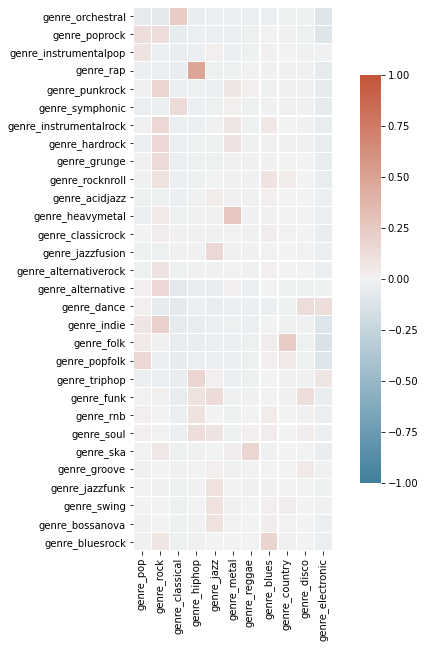

In [12]:

# create heatmap to identify possible parent genre for unidentified genres
# (including electronic as a pseudo base-genre so we can identify if we should
# actually discard any of the unknown genres)

# get the full correlation matrix for all genres
c = df[base_genres+identified_subgenres+unidentified_genres+['genre_electronic']].corr()

# filter out unknown genres from the heatmap's X-axis, then the base genres
# from the heatmap's Y-axis
c = c.loc[identified_subgenres+unidentified_genres][base_genres+['genre_electronic']]

plt.figure(facecolor='white',figsize=[10,10])
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=c,  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
# show the heatmap
plt.show()


In [17]:
# get number of base genres tagged to each song
base_genre_counts = pd.DataFrame(
    df[base_genres].sum(axis=1),
    columns=['base_genre_counts']
)
# get number of relevant sub genres tagged to each song
subgenre_counts = pd.DataFrame(
    df[identified_subgenres].sum(axis=1),
    columns=['subgenre_counts']
)
# get number of unknown genres for each song
unidentified_genre_counts = pd.DataFrame(
    df[unidentified_genres].sum(axis=1),
    columns=['unidentified_genre_counts']
)
# combine into one dataframe containing genre counts
genre_meta_counts = pd.concat([
    base_genre_counts,
    subgenre_counts,
    unidentified_genre_counts   
],axis=1)

in_scope_songs = df.join(
    # create full dataframe containing songs that meet any of the 3 above criteria
    # (omit known songs to be out-of-scope)
    genre_meta_counts[
        (genre_meta_counts['base_genre_counts'] > 0)
        | (genre_meta_counts['subgenre_counts'] > 0)
        | (genre_meta_counts['unidentified_genre_counts'] > 0)
    ]
,how="inner")

# get songs with at least one unknown/sub genre, but no base genre tags
dangling_songs = in_scope_songs[
    (in_scope_songs['base_genre_counts'] == 0)
    # & (in_scope_songs['subgenre_counts'] == 0)
    & (in_scope_songs['unidentified_genre_counts'] > 0)
]

# get songs with multiple base genres (that we will need to decide which base genre
# they will be assigned to)
multi_base_genres = in_scope_songs[
    (in_scope_songs['base_genre_counts'] > 1)
]

print(f'Total songs: {len(df)}')
print(f'Songs in scope: {len(in_scope_songs)}')
print(f'Songs in scope with no base genre: {len(dangling_songs)}')
print(f'Songs in scope with conflicting (multiple) base genres: {len(multi_base_genres)}')



Total songs: 55213
Songs in scope: 36342
Songs in scope with no base genre: 7640
Songs in scope with conflicting (multiple) base genres: 4211
